In [1]:
import os
os.environ['R_HOME'] = '/disco_500t/xuhua/miniforge3/envs/Seurat5/lib/R'
os.environ['R_USER'] = '/disco_500t/xuhua/miniforge3/envs/Seurat5/lib/python3.8/site-packages/rpy2'

import psutil

# Get the current process
# p = psutil.Process(os.getpid())

# # Set the process to run only on the first CPU core
# p.cpu_affinity([5])

In [2]:
import os
import gc
import pandas as pd
import pickle
import matplotlib.pyplot as plt

import anndata as ad
import numpy as np
import yaml
import sys
import h5py
import logging
import scanpy as sc
from os.path import join
import scipy.sparse as sps
from sklearn.cluster import KMeans

import scglue

import warnings
def wrap_warn_plot(adata, basis, color, **kwargs):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=UserWarning)
        sc.pl.embedding(adata, basis=basis, color=color, **kwargs)

def get_umap(ad, use_reps=[]):
    for use_rep in use_reps:
        umap_add_key = f'{use_rep}_umap'
        sc.pp.neighbors(ad, use_rep=use_rep, n_neighbors=15)
        sc.tl.umap(ad)
        ad.obsm[umap_add_key] = ad.obsm['X_umap']
    return ad

from sklearn.metrics import adjusted_rand_score

def split_ob(ads, ad_ref, ob='obs', key='emb2'):
    len_ads = [_.n_obs for _ in ads]
    if ob=='obsm':
        split_obsms = np.split(ad_ref.obsm[key], np.cumsum(len_ads[:-1]))
        for ad, v in zip(ads, split_obsms):
            ad.obsm[key] = v
    else:
        split_obs = np.split(ad_ref.obs[key].to_list(), np.cumsum(len_ads[:-1]))
        for ad, v in zip(ads, split_obs):
            ad.obs[key] = v

def eval_ads(ads, ref_key, src_key):
    aris = []
    for ad in ads:
        aris.append(adjusted_rand_score(ad.obs[src_key], ad.obs[ref_key]))
    return aris

from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
def search_louvain(ad, use_rep, n_neighbors=15, n_clusters=5):
    sc.pp.neighbors(ad, n_neighbors=n_neighbors, use_rep=use_rep)
    rs = np.arange(0.1, 1.0, 0.1)
    n_cs = []
    for r in rs:
        sc.tl.louvain(ad, resolution=r, key_added=f'r={r}')
        n_cs.append(ad.obs[f'r={r}'].nunique())
    n_cs = np.array(n_cs)
    if (n_cs==n_clusters).sum() >= 1:
        ri = np.where(n_cs==n_clusters)[0][0]
        ad.obs['louvain_k'] = ad.obs[f'r={rs[ri]}'].to_list()
    else:
        kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(ad.obsm[use_rep])
        ad.obs['louvain_k'] = kmeans.labels_.astype('str')

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
def eval_labelTransfer(ad1, ad2, use_rep, lab_key, knn=10):
     with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)
        neigh1 = KNeighborsClassifier(n_neighbors=knn)
        neigh1.fit(ad1.obsm[use_rep], ad1.obs[lab_key].to_list())
        pr_lab2 = neigh1.predict(ad2.obsm[use_rep])
        f1_1 = f1_score(ad2.obs[lab_key].values, pr_lab2, #labels=['1.0', '2.0', '3.0', '4.0'], 
                        average='macro')
        # acc1 = (pr_lab2 == ad2.obs[lab_key].values).mean()
    
        neigh2 = KNeighborsClassifier(n_neighbors=knn)
        neigh2.fit(ad2.obsm[use_rep], ad2.obs[lab_key].to_list())
        pr_lab1 = neigh2.predict(ad1.obsm[use_rep])
        # acc2 = (pr_lab1 == ad1.obs[lab_key].values).mean()
        f1_2 = f1_score(ad1.obs[lab_key].values, pr_lab1, #labels=['1.0', '2.0', '3.0', '4.0'], 
                        average='macro')
        return (f1_1+f1_2)/2

from scib.metrics import lisi
def eval_lisi(
        adata,
        batch_keys=['domain', 'batch'],
        label_keys = ['gt'],
        use_rep='X_emb', use_neighbors=False,
    ):
    res = {}
    for key in batch_keys:
        adata.obs[key] = adata.obs[key].astype('category')

        _lisi = lisi.ilisi_graph(
            adata,
            key,
            'embed' if not use_neighbors else 'knn',
            use_rep=use_rep,
            k0=90,
            subsample=None,
            scale=True,
            n_cores=1,
            verbose=False,
        )
        res[key+'_iLISI'] = _lisi
    for key in label_keys:
        adata.obs[key] = adata.obs[key].astype('category')

        _lisi = lisi.clisi_graph(
            adata,
            key,
            'embed' if not use_neighbors else 'knn',
            use_rep=use_rep,
            batch_key=None,
            k0=90,
            subsample=None,
            scale=True,
            n_cores=1,
            verbose=False,
        )
        res[key+'_cLISI'] = _lisi
    df = pd.DataFrame.from_dict(res, orient='index').T
    # df.columns = [_+'_LISI' for _ in df.columns]
    return df

os.environ['R_HOME'] = '/disco_500t/xuhua/miniforge3/envs/Seurat5/lib/R'
os.environ['R_USER'] = '/disco_500t/xuhua/miniforge3/envs/Seurat5/lib/python3.8/site-packages/rpy2'
def mclust_R(adata, num_cluster, modelNames='EEE', used_obsm='STAGATE', random_seed=2020):
    np.random.seed(random_seed)
    import rpy2.robjects as robjects
    robjects.r.library("mclust")

    import rpy2.robjects.numpy2ri
    rpy2.robjects.numpy2ri.activate()
    r_random_seed = robjects.r['set.seed']
    r_random_seed(random_seed)
    rmclust = robjects.r['Mclust']

    res = rmclust(rpy2.robjects.numpy2ri.numpy2rpy(adata.obsm[used_obsm]), num_cluster, modelNames)
    mclust_res = np.array(res[-2])

    adata.obs['mclust'] = mclust_res
    adata.obs['mclust'] = adata.obs['mclust'].astype('int')
    adata.obs['mclust'] = adata.obs['mclust'].astype('category')
    return adata

def flip_coords(ads):
    for ad in ads:
        ad.obsm['spatial'] = -1 * ad.obsm['spatial']
        ad.obsm['spatial'] = ad.obsm['spatial'][:, ::-1]

def reorder(ad1, ad2):
    shared_barcodes = ad1.obs_names.intersection(ad2.obs_names)
    ad1 = ad1[shared_barcodes].copy()
    ad2 = ad2[shared_barcodes].copy()
    return ad1, ad2

def load_peak_expr(_dir):
    data = sio.mmread(join(_dir, 'data.mtx'))
    cname = pd.read_csv(join(_dir, 'barcode.csv'), index_col=0)['x'].to_list()
    feat = pd.read_csv(join(_dir, 'feat.csv'), index_col=0)['x'].to_list()
    ad = sc.AnnData(sps.csr_matrix(data.T))
    ad.obs_names = cname
    ad.var_names = feat
    return ad

In [3]:
def set_col2cat(ad, cols=[]):
    for col in cols:
        ad.obs[col] = ad.obs[col].astype('category')

def unify_colors(queries, color_key, ref_color_dict):
    for q in queries:
        q.obs[color_key] = q.obs[color_key].astype('category')
        q.uns[f'{color_key}_colors'] = [ref_color_dict[_] for _ in q.obs[color_key].cat.categories]
    return queries

def subset_ad(ad, subset_index):
    ad = ad[subset_index].copy()
    return ad

def add_name_prefix(list, prefix):
    new_list = [f'{prefix}-{x}' for x in list]
    return new_list

### Training and running

In [4]:
sys.path.insert(0, './resources')
import utils
import scipy.io as sio

In [5]:
out_dir = './cache/MB_RNA+ATAC+Histone'
os.makedirs(out_dir, exist_ok=True)
## best setting for simulation experiments
# n_genes = 10000
# x2u_h_depth = 2
# x2u_h_dim = 512 
# u2x_h_depth = 1
# du_h_depth = 2
# dropout = 0.2
# lam_data = 1.0
# lam_kl = 1.0  
# lam_align = 2.0   
# lam_cross = 2.0 
# lam_cos = 1.0 
# normalize_u = True
# random_seed = 5
# latent_dim = 50
# u2x_h_dim = 256
# du_h_dim  = u2x_h_dim
# du_h_depth = 2

## multiome setting
n_genes = 10000
latent_dim = 50
x2u_h_depth = 2
x2u_h_dim = 512
u2x_h_depth = 1
u2x_h_dim = 256
du_h_depth = 1
du_h_dim = 256
dropout = 0.2
lam_data = 1.0
lam_kl = 0.3
lam_align = 0.02
lam_cross = 1.0
lam_cos = 0.02
normalize_u = True
random_seed = 2

max_epochs1 = 400
max_epochs2 = 50

In [6]:
# rna+H3K27me3
data_dir = '/disco_500t/xuhua/data/real_mosaic_cases/mouse_brain_rna+H3K27me3'
df_mult_rna = pd.read_csv(join(data_dir, 'rna+H3K27me3/GSM6753044_MouseBrain_20um_100barcodes_H3K27me3_matrix.tsv'), sep='\t')
df_mult_rna_spatial = pd.read_csv(join(data_dir, 'rna+H3K27me3/spatial/tissue_positions_list.csv'), header=None, index_col=0)
ad_mult_rna = sc.AnnData(df_mult_rna.T, obsm={'spatial': df_mult_rna_spatial.loc[df_mult_rna.columns, [2, 3]].values})
ad_mult_rna.layers['counts'] = ad_mult_rna.X.copy()

ad_mult_atac = load_peak_expr(join(data_dir, 'rna+H3K27me3/peak_data'))
df_mult_atac_spatial = pd.read_csv(join(data_dir, 'rna+H3K27me3/spatial/tissue_positions_list.csv'), header=None, index_col=0)
ad_mult_atac.obsm['spatial'] = df_mult_atac_spatial.loc[ad_mult_atac.obs_names, [2, 3]].values
ad_mult_atac.layers['counts'] = ad_mult_atac.X.copy()

ad_mult_rna, ad_mult_atac = reorder(ad_mult_rna, ad_mult_atac)

# rna+H3K4me3
data_dir = '/disco_500t/xuhua/data/real_mosaic_cases/mouse_brain_rna+H3K4me3'
df_mult_rna2 = pd.read_csv(join(data_dir, 'rna+H3K4me3/GSM6753046_MouseBrain_20um_100barcodes_H3K4me3_matrix.tsv'), sep='\t')
df_mult_rna_spatial2 =pd.read_csv(join(data_dir, 'rna+H3K4me3/spatial/tissue_positions_list.csv'), header=None, index_col=0)
ad_mult_rna2 = sc.AnnData(df_mult_rna2.T, obsm={'spatial': df_mult_rna_spatial2.loc[df_mult_rna2.columns, [2, 3]].values})
ad_mult_rna2.layers['counts'] = ad_mult_rna2.X.copy()

ad_mult_atac2 = load_peak_expr(join(data_dir, 'rna+H3K4me3/peak_data'))
df_mult_atac_spatial2 = pd.read_csv(join(data_dir, 'rna+H3K4me3/spatial/tissue_positions_list.csv'), header=None, index_col=0)
ad_mult_atac2.obsm['spatial'] = df_mult_atac_spatial2.loc[ad_mult_atac2.obs_names, [2, 3]].values
ad_mult_atac2.layers['counts'] = ad_mult_atac2.X.copy()

ad_mult_rna2, ad_mult_atac2 = reorder(ad_mult_rna2, ad_mult_atac2)

# rna+H3K27ac
data_dir = '/disco_500t/xuhua/data/real_mosaic_cases/mouse_brain_rna+H3K27ac/'
df_mult_rna3 = pd.read_csv(join(data_dir, 'rna+atac/GSM6753045_MouseBrain_20um_100barcodes_H3K27ac_matrix.tsv'), sep='\t')
df_mult_rna_spatial3 = pd.read_csv(join(data_dir, 'rna+atac/GSM6753045_spatial/tissue_positions_list.csv'), index_col=0, header=None)
ad_mult_rna3 = sc.AnnData(df_mult_rna3.T, obsm={'spatial': df_mult_rna_spatial3.loc[df_mult_rna3.columns, [2, 3]].values})
ad_mult_rna3.layers['counts'] = ad_mult_rna3.X.copy()

ad_mult_atac3 = load_peak_expr(join(data_dir, 'rna+atac/peak_data_3slices/GSM6753045_peak_data'))
df_mult_atac_spatial3 = pd.read_csv(join(data_dir, 'rna+atac/GSM6753045_spatial/tissue_positions_list.csv'), index_col=0, header=None)
ad_mult_atac3.obsm['spatial'] = df_mult_atac_spatial3.loc[ad_mult_atac3.obs_names, [2, 3]].values
ad_mult_atac3.layers['counts'] = ad_mult_atac3.X.copy()

ad_mult_rna3, ad_mult_atac3 = reorder(ad_mult_rna3, ad_mult_atac3)

# rna+atac
data_dir = '/disco_500t/xuhua/data/real_mosaic_cases/mouse_brain_rna+atac/'
df_mult_rna4 = pd.read_csv(join(data_dir, 'rna+atac/GSM6753043_MouseBrain_20um_100barcodes_ATAC_matrix.tsv'), sep='\t')
df_mult_rna_spatial4 = pd.read_csv(join(data_dir, 'rna+atac/GSM6753043_MouseBrain_20um_100barcodes_ATAC_spatial/tissue_positions_list.csv'), header=None, index_col=0)
ad_mult_rna4 = sc.AnnData(df_mult_rna4.T, obsm={'spatial': df_mult_rna_spatial4.loc[df_mult_rna4.columns, [2, 3]].values})
ad_mult_rna4.layers['counts'] = ad_mult_rna4.X.copy()

ad_mult_atac4 = load_peak_expr(join(data_dir, 'rna+atac/For_Imputation_Task/GSM6758285_peak_data'))
df_mult_atac_spatial4 = pd.read_csv(join(data_dir, 'rna+atac/GSM6753043_MouseBrain_20um_100barcodes_ATAC_spatial/tissue_positions_list.csv'), header=None, index_col=0)
ad_mult_atac4.obsm['spatial'] = df_mult_atac_spatial4.loc[ad_mult_atac4.obs_names, [2, 3]].values
ad_mult_atac4.layers['counts'] = ad_mult_atac4.X.copy()

ad_mult_rna4, ad_mult_atac4 = reorder(ad_mult_rna4, ad_mult_atac4)

In [7]:
def flip_coords(ads):
    for ad in ads:
        ad.obsm['spatial'][:, 1] = -1 * ad.obsm['spatial'][:, 1]
        
flip_coords([ad_mult_rna, ad_mult_rna2, ad_mult_rna3, ad_mult_rna4])

In [8]:
# shared_gene = ad_mult_rna.var_names
# for ad in [ad_mult_rna2, ad_mult_rna3, ad_mult_rna4]:
#     shared_gene = np.intersect1d(ad.var_names, shared_gene)
# for ad in [ad_mult_rna, ad_mult_rna2, ad_mult_rna3, ad_mult_rna4]:
#     ad = ad[:, shared_gene].copy()

ad_mult_rna.obs_names = ad_mult_atac.obs_names = add_name_prefix(ad_mult_rna.obs_names, 'rna+H3K27me3')
ad_mult_rna2.obs_names = ad_mult_atac2.obs_names = add_name_prefix(ad_mult_rna2.obs_names, 'rna+H3K4me3')
ad_mult_rna3.obs_names = ad_mult_atac3.obs_names = add_name_prefix(ad_mult_rna3.obs_names, 'rna+H3K27ac')
ad_mult_rna4.obs_names = ad_mult_atac4.obs_names = add_name_prefix(ad_mult_rna4.obs_names, 'rna+atac')

ad_mult_rna.obs['src'] = ad_mult_atac.obs['src'] = ['rna+H3K27me3']*ad_mult_rna.n_obs
ad_mult_rna2.obs['src'] = ad_mult_atac2.obs['src'] = ['rna+H3K4me3']*ad_mult_rna2.n_obs
ad_mult_rna3.obs['src'] = ad_mult_atac3.obs['src'] = ['rna+H3K27ac']*ad_mult_rna3.n_obs
ad_mult_rna4.obs['src'] = ad_mult_atac4.obs['src'] = ['rna+atac']*ad_mult_rna4.n_obs

In [9]:
ad_rna_all = sc.concat([ad_mult_rna, ad_mult_rna2, ad_mult_rna3, ad_mult_rna4])

sc.pp.highly_variable_genes(ad_rna_all, flavor='seurat_v3', n_top_genes=10000, batch_key='src')
hvg_names = ad_rna_all.var.query('highly_variable').index.to_numpy()
ad_rna_all = ad_rna_all[:, hvg_names].copy()

HVP_NAMES = []
for ad in [ad_mult_atac, ad_mult_atac2, ad_mult_atac3, ad_mult_atac4]:
    sc.pp.highly_variable_genes(ad, flavor='seurat_v3', n_top_genes=100000)
    hvp_names = (ad.var.query('highly_variable').index.to_numpy())
    HVP_NAMES.append(hvp_names)

In [11]:
ad_mult_atac = ad_mult_atac[:, HVP_NAMES[0]].copy()
ad_mult_atac2 = ad_mult_atac2[:, HVP_NAMES[1]].copy()
ad_mult_atac3 = ad_mult_atac3[:, HVP_NAMES[2]].copy()
ad_mult_atac4 = ad_mult_atac4[:, HVP_NAMES[3]].copy()

ad_rna_all.X    = sps.csr_matrix(ad_rna_all.X)
ad_mult_atac.X  = sps.csr_matrix(ad_mult_atac.X)
ad_mult_atac2.X = sps.csr_matrix(ad_mult_atac2.X)
ad_mult_atac3.X = sps.csr_matrix(ad_mult_atac3.X)
ad_mult_atac4.X = sps.csr_matrix(ad_mult_atac4.X)

ad_rna_all.layers['counts'] = sps.csr_matrix(ad_rna_all.X)
ad_mult_atac.layers['counts'] = sps.csr_matrix(ad_mult_atac.X)
ad_mult_atac2.layers['counts'] = sps.csr_matrix(ad_mult_atac2.X)
ad_mult_atac3.layers['counts'] = sps.csr_matrix(ad_mult_atac3.X)
ad_mult_atac4.layers['counts'] = sps.csr_matrix(ad_mult_atac4.X)

ad_rna_all.obs["uid"] = ad_rna_all.obs_names.to_list()
ad_mult_atac.obs["uid"] = ad_mult_atac.obs_names.to_list()
ad_mult_atac2.obs["uid"] = ad_mult_atac2.obs_names.to_list()
ad_mult_atac3.obs["uid"] = ad_mult_atac3.obs_names.to_list()
ad_mult_atac4.obs["uid"] = ad_mult_atac4.obs_names.to_list()

ad_rna_all.obs["batch"] = ad_rna_all.obs['src'].to_list()
ad_mult_atac.obs["batch"] = ad_mult_atac.obs['src'].to_list()
ad_mult_atac2.obs["batch"] = ad_mult_atac2.obs['src'].to_list()
ad_mult_atac3.obs["batch"] = ad_mult_atac3.obs['src'].to_list()
ad_mult_atac4.obs["batch"] = ad_mult_atac4.obs['src'].to_list()

print('Reading `h5ad` files...')
omics = "multiome"

print('Preprocessing GEX...')
gex_prep = utils.GEXPreprocessing(n_comps=100, n_genes=n_genes, merge_adt=omics == "cite")
gex_prep.fit_transform(ad_rna_all)
print('Preprocessing ATAC...')
other_prep1 = utils.ATACPreprocessing(n_comps=100)
other_prep1.fit_transform(ad_mult_atac)
other_prep2 = utils.ATACPreprocessing(n_comps=100)
other_prep2.fit_transform(ad_mult_atac2)
other_prep3 = utils.ATACPreprocessing(n_comps=100)
other_prep3.fit_transform(ad_mult_atac3)
other_prep4 = utils.ATACPreprocessing(n_comps=100)
other_prep4.fit_transform(ad_mult_atac4)

with open(os.path.join(out_dir, "prep.pickle"), "wb") as f:
    pickle.dump({
        "gex_prep": gex_prep,
        "other_prep1": other_prep1,
        "other_prep2": other_prep2,
        "other_prep3": other_prep3,
        "other_prep4": other_prep4
    }, f)

with open(f"{out_dir}/hyperparams.yaml", "w") as f:
    yaml.dump({
        "n_genes": n_genes,
        "latent_dim": latent_dim,
        "x2u_h_depth": x2u_h_depth,
        "x2u_h_dim": x2u_h_dim,
        "u2x_h_depth": u2x_h_depth,
        "u2x_h_dim": u2x_h_dim,
        "du_h_depth": du_h_depth,
        "du_h_dim": du_h_dim,
        "dropout": dropout,
        "lam_data": lam_data,
        "lam_kl": lam_kl,
        "lam_align": lam_align,
        "lam_cross": lam_cross,
        "lam_cos": lam_cos,
        "normalize_u": normalize_u,
        "random_seed": random_seed
    }, f)

scglue.models.configure_dataset(
    ad_rna_all, "NB", use_highly_variable=True,
    use_layer="counts", use_rep="X_pca",
    use_batch="batch", use_uid="uid"
)
scglue.models.configure_dataset(
    ad_mult_atac, "NB", use_highly_variable=True,
    use_layer="counts", use_rep="X_lsi",
    use_batch="batch", use_uid="uid"
)
scglue.models.configure_dataset(
    ad_mult_atac2, "NB", use_highly_variable=True,
    use_layer="counts", use_rep="X_lsi",
    use_batch="batch", use_uid="uid"
)
scglue.models.configure_dataset(
    ad_mult_atac3, "NB", use_highly_variable=True,
    use_layer="counts", use_rep="X_lsi",
    use_batch="batch", use_uid="uid"
)
scglue.models.configure_dataset(
    ad_mult_atac4, "NB", use_highly_variable=True,
    use_layer="counts", use_rep="X_lsi",
    use_batch="batch", use_uid="uid"
)

print('Building model...')
model = scglue.models.SCCLUEModel(
    {"gex": ad_rna_all, "atac1": ad_mult_atac, "atac2":ad_mult_atac2, "atac3":ad_mult_atac3, 'atac4':ad_mult_atac4},
    latent_dim=latent_dim,
    x2u_h_depth=x2u_h_depth,
    x2u_h_dim=x2u_h_dim,
    u2x_h_depth=u2x_h_depth,
    u2x_h_dim=u2x_h_dim,
    du_h_depth=du_h_depth,
    du_h_dim=du_h_dim,
    dropout=dropout,
    shared_batches=False,
    random_seed=random_seed
)

print('Compiling model...')
model.compile(
    lam_data=lam_data, lam_kl=lam_kl, lam_align=lam_align,
    lam_cross=lam_cross, lam_cos=lam_cos, normalize_u=normalize_u,
    domain_weight={"gex": 1, "atac1": 1, 'atac2':1, 'atac3': 1, 'atac4':1}
)

# help(model.fit)
print('Training model...')
model.fit(
    {"gex": ad_rna_all, "atac1": ad_mult_atac, "atac2":ad_mult_atac2, "atac3":ad_mult_atac3, 'atac4':ad_mult_atac4}, 
    max_epochs=max_epochs1,
)
model.save(os.path.join(out_dir, "pretrain.dill"))
# no stage2 because of no test batches

logging.info('Projecting cell embeddings...')
ad_rna_all.obsm["X_model"] = model.encode_data("gex", ad_rna_all)
ad_mult_atac.obsm["X_model"] = model.encode_data("atac1", ad_mult_atac)
ad_mult_atac2.obsm["X_model"] = model.encode_data("atac2", ad_mult_atac2)
ad_mult_atac3.obsm["X_model"] = model.encode_data("atac3", ad_mult_atac3)
ad_mult_atac4.obsm["X_model"] = model.encode_data("atac4", ad_mult_atac4)

split_ob([ad_mult_rna, ad_mult_rna2, ad_mult_rna3, ad_mult_rna4], ad_rna_all, ob='obsm', key='X_model')

ad_mult1 = sc.AnnData(
    (ad_mult_rna.obsm['X_model'] + ad_mult_atac.obsm['X_model'])/2, 
    obs=ad_mult_rna.obs.copy(),
    obsm={'spatial': ad_mult_rna.obsm['spatial']}
)
ad_mult2 = sc.AnnData(
    (ad_mult_rna2.obsm['X_model'] + ad_mult_atac2.obsm['X_model'])/2, 
    obs=ad_mult_rna2.obs.copy(),
    obsm={'spatial': ad_mult_rna2.obsm['spatial']}
)
ad_mult3 = sc.AnnData(
    (ad_mult_rna3.obsm['X_model'] + ad_mult_atac3.obsm['X_model'])/2, 
    obs=ad_mult_rna3.obs.copy(),
    obsm={'spatial': ad_mult_rna3.obsm['spatial']}
)
ad_mult4 = sc.AnnData(
    (ad_mult_rna4.obsm['X_model'] + ad_mult_atac4.obsm['X_model'])/2, 
    obs=ad_mult_rna4.obs.copy(),
    obsm={'spatial': ad_mult_rna4.obsm['spatial']}
)

ad_mosaic = sc.concat([ad_mult1, ad_mult2, ad_mult3, ad_mult4])

Reading `h5ad` files...
Preprocessing GEX...
Preprocessing ATAC...
Building model...
[INFO] autodevice: Using GPU 2 as computation device.
Compiling model...
Training model...
[INFO] SCCLUEModel: Setting `align_burnin` = 23
[INFO] SCCLUEModel: Setting `patience` = 17
[INFO] SCCLUEModel: Setting `reduce_lr_patience` = 6
[INFO] SCCLUETrainer: Using training directory: "/tmp/GLUETMP1qda4ig5"
[INFO] SCCLUETrainer: [Epoch 10] train={'dsc_loss': 1.558, 'gen_loss': 1.821, 'cross_loss': 0.916, 'cos_loss': 0.386, 'x_gex_nll': 0.235, 'x_gex_kl': 0.028, 'x_gex_elbo': 0.244, 'x_atac1_nll': 0.111, 'x_atac1_kl': 0.008, 'x_atac1_elbo': 0.114, 'x_atac2_nll': 0.179, 'x_atac2_kl': 0.009, 'x_atac2_elbo': 0.182, 'x_atac3_nll': 0.177, 'x_atac3_kl': 0.009, 'x_atac3_elbo': 0.179, 'x_atac4_nll': 0.208, 'x_atac4_kl': 0.008, 'x_atac4_elbo': 0.211}, val={'dsc_loss': 1.581, 'gen_loss': 1.836, 'cross_loss': 0.92, 'cos_loss': 0.372, 'x_gex_nll': 0.234, 'x_gex_kl': 0.027, 'x_gex_elbo': 0.243, 'x_atac1_nll': 0.116, '

2024-04-30 18:09:51,405 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "41"...
[INFO] EarlyStopping: Restoring checkpoint "41"...


In [15]:
ad_mosaic.obsm['emb'] = ad_mosaic.X.copy()

In [22]:
ad_mosaic = get_umap(ad_mosaic, ['emb'])

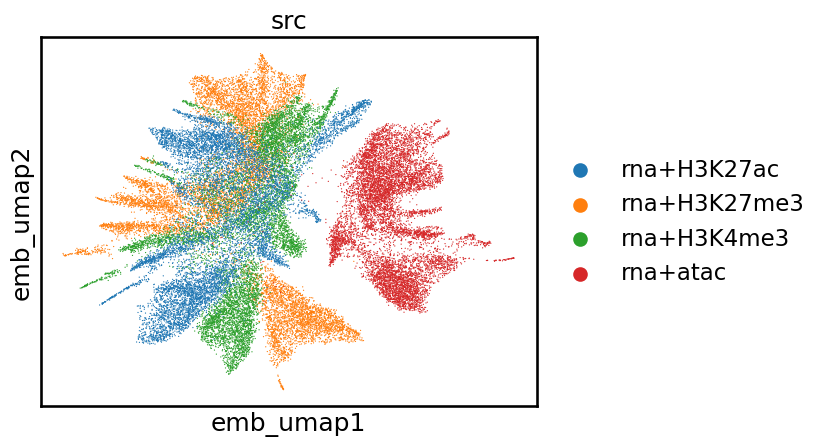

/home/xuhua/xuhua_disco/miniforge3/envs/Squidpy/lib/python3.8/tempfile.py:818: ResourceWarning: Implicitly cleaning up <TemporaryDirectory '/tmp/tmp1c3k45g8'>
  _warnings.warn(warn_message, ResourceWarning)


In [23]:
wrap_warn_plot(ad_mosaic, 'emb_umap', ['src'])

In [16]:
lisi_res = eval_lisi(
    ad_mosaic,
    batch_keys=['src'],
    label_keys = [],
    use_rep='emb', use_neighbors=False,
)
lisi_res['src_iLISI'][0]

/home/xuhua/xuhua_disco/miniforge3/envs/Squidpy/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


0.04584765397631885

### batch corr

In [18]:
from batchCorr import HARMONY

ad_mosaic.obsm['emb_har'] = HARMONY(pd.DataFrame(ad_mosaic.obsm['emb']), ad_mosaic.obs['src'].to_list())
# split_ob([ad_mult1, ad_mult2, ad_mult3, ad_mult4], ad_mosaic, ob='obsm', key='emb_har')

In [ ]:
# try:
    
#     # from sklearn.cluster import KMeans
#     # print("mclust failed, try kmeans")
#     # kmeans = KMeans(n_clusters=ad_mosaic.obs['Combined_Clusters_annotation'].nunique(), random_state=0).fit(ad_mosaic.obsm['emb_har'])
#     # ad_mosaic.obs['kmeans'] = kmeans.labels_.astype('str')
#     # clust_key = 'kmeans'

#     ad_mosaic = mclust_R(ad_mosaic, ad_mosaic.obs.Combined_Clusters_annotation.nunique(), used_obsm='emb_har')  
#     clust_key = 'mclust'

# except:

#     # ad_mosaic = mclust_R(ad_mosaic, ad_mosaic.obs.Combined_Clusters_annotation.nunique(), used_obsm='emb_har')  
#     # clust_key = 'mclust'

#     from sklearn.cluster import KMeans
#     print("mclust failed, try kmeans")
#     kmeans = KMeans(n_clusters=ad_mosaic.obs['Combined_Clusters_annotation'].nunique(), random_state=0).fit(ad_mosaic.obsm['emb_har'])
#     ad_mosaic.obs['kmeans'] = kmeans.labels_.astype('str')
#     clust_key = 'kmeans'
    
# split_ob([ad_train_mean_enc, input_test_mod1, input_test_mod2], ad_mosaic, ob='obs',  key=clust_key)
# ad_mosaic.obs['after_clust'] = ad_mosaic.obs[clust_key].to_list()

In [19]:
lisi_res = eval_lisi(
    ad_mosaic,
    batch_keys=['src'],
    label_keys = [],
    use_rep='emb_har', use_neighbors=False,
)
r2 = lisi_res['src_iLISI'][0]

In [20]:
r2

0.11469604484639095

In [21]:
fig_dir = f'/disco_500t/xuhua/gitrepo/BridgeNorm/figures/MB_RNA+ATAC+Histone/clue'
os.makedirs(fig_dir, exist_ok=True)

df = pd.DataFrame(ad_mosaic.obsm['emb'], index=ad_mosaic.obs_names.to_list())
# df['before_clust'] = ad_mosaic.obs['before_clust'].to_list() 
df.to_csv(join(fig_dir, 'X_emb.csv'))

df = pd.DataFrame(ad_mosaic.obsm['emb_har'], index=ad_mosaic.obs_names.to_list())
# df['after_clust'] = ad_mosaic.obs['after_clust'].to_list() 
df.to_csv(join(fig_dir, 'X_emb_har.csv'))

In [ ]:
1